<a href="https://colab.research.google.com/github/HEM2058/sentinelhub_remote_sensing/blob/main/NDVI_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install sentinelhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.6/245.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 891.1 kB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=e23cc7f312937716844716c1a3e40893160b9480e04b65f1a6fe789def62339f
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [51]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes
import folium

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
 [
            [
              83.93760288558025,
              28.2595991708927
            ],
            [
              83.9408436340845,
              28.24896427221401
            ],
            [
              83.95094714412392,
              28.24734095752504
            ],
            [
              83.956983832513,
              28.25047561195197
            ],
            [
              83.95806408201503,
              28.255009502639425
            ],
            [
              83.95272637859762,
              28.260942451047143
            ],
            [
              83.94789702788665,
              28.26390880141416
            ],
            [
              83.94103426634786,
              28.265196059847156
            ],
            [
              83.93760288558025,
              28.2595991708927
            ]
          ]
    ]
}


polygon = shape(geojson_polygon)

# Define bounding box based on the polygon
bbox = rasterio.features.bounds(polygon)

# Create BBox object
bbox = BBox(bbox=(bbox[0], bbox[1], bbox[2], bbox[3]), crs=CRS.WGS84)


# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1, sampleType: "FLOAT32" } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  // Return NDVI value
  return [ndvi];
}
"""

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,  # Use the calculated bounding box
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Define geospatial information
transform = rasterio.transform.from_bounds(*bbox, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] = 5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    classified_array[(ndvi_array > 0.7) & (ndvi_array <= 1)] = 8
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
# print(intersection_df)




# Define color palette for each class
class_colors = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red',
    6: 'purple',
    7: 'pink',
    8: 'cyan'
}

# Create a Folium map centered around the polygon
m = folium.Map(location=[28.246840164244404, 83.93433379460498], zoom_start=15)

# Create a dictionary to store color for each class
class_color_dict = {}

# Iterate through the features and assign color based on class number
for feature in intersection_df.iterrows():
    class_no = feature[1]['class_no']
    if class_no not in class_color_dict:
        class_color_dict[class_no] = class_colors[len(class_color_dict) + 1]  # Assign a new color
    color = class_color_dict[class_no]
    folium.GeoJson(feature[1]['geometry'], style_function=lambda x, color=color: {'color': color}).add_to(m)

# Display the map
m



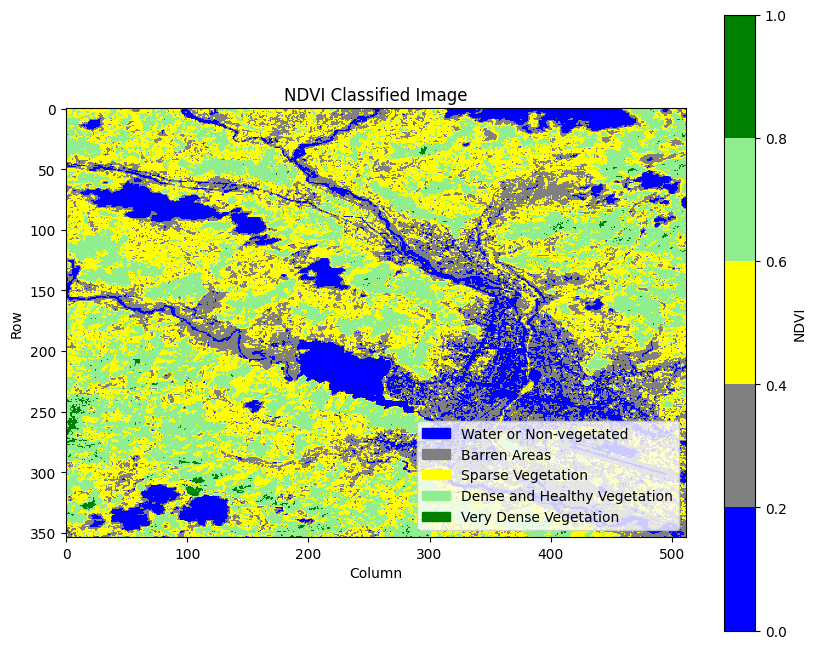

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

# Sample NDVI image data
ndvi_image = response[0]  # Assuming response[0] contains the NDVI data in matrix format

# Define the NDVI classification thresholds and corresponding labels
thresholds = [0, 0.3, 0.6, 0.9, 1]
labels = ['Water or Non-vegetated', 'Barren Areas', 'Sparse Vegetation', 'Dense and Healthy Vegetation', 'Very Dense Vegetation']

# Define colors for each class
colors = ['blue', 'gray', 'yellow', 'lightgreen', 'green']

# Create a colormap based on the defined colors
cmap = ListedColormap(colors)

# Normalize the NDVI values to the range [0, 1]
norm = Normalize(vmin=0, vmax=1)

# Plot the NDVI image with colormap
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_image, cmap=cmap, norm=norm)
plt.colorbar(label='NDVI')
plt.title('NDVI Classified Image')
plt.xlabel('Column')
plt.ylabel('Row')

# Create legend
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_handles, loc='lower right')

plt.show()


In [23]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
[
            [
              83.92967233590457,
              28.2490505439186
            ],
            [
              83.92908937633854,
              28.247411726272375
            ],
            [
              83.93049498923824,
              28.247142547359303
            ],
            [
              83.93248118138047,
              28.2467926137563
            ],
            [
              83.93335205024238,
              28.24792316433596
            ],
            [
              83.93390445300588,
              28.249508139479886
            ],
            [
              83.93274329452277,
              28.250517534508788
            ],
            [
              83.93257523211156,
              28.250275280573618
            ],
            [
              83.9309251647935,
              28.249938815861242
            ],
            [
              83.92967233590457,
              28.2490505439186
            ]
          ]
    ]
}

polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    print(ndvi_array)
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_data)


[[0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 ...
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]]
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93453651677848, 28.247151041120986), (83.93453651677848, 28.247126336750846), (83.93454441504498, 28.247126336750846), (83.93454441504498, 28.247124090899014), (83.93463656148748, 28.247124090899014), (83.93463656148748, 28.247144303565495), (83.93463919424298, 28.247144303565495), (83.93463919424298, 28.247151041120986), (83.93453651677848, 28.247151041120986)]]}, 'properties': {'class_no': 6.0}}, {'type': 'Feature', 'geometry': {'type

In [24]:
import geopandas as gpd
from shapely.geometry import mapping

# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
print(intersection_df)


                                             geometry  class_no
3   POLYGON ((83.93472 28.24694, 83.93472 28.24694...       6.0
5   POLYGON ((83.93440 28.24695, 83.93440 28.24695...       5.0
2   POLYGON ((83.93484 28.24703, 83.93484 28.24703...       6.0
1   POLYGON ((83.93453 28.24702, 83.93453 28.24702...       4.0
12  POLYGON ((83.93462 28.24666, 83.93463 28.24666...       3.0
10  POLYGON ((83.93564 28.24647, 83.93564 28.24648...       4.0
7   POLYGON ((83.93564 28.24665, 83.93564 28.24665...       3.0
6   POLYGON ((83.93542 28.24675, 83.93542 28.24674...       5.0
9   MULTIPOLYGON (((83.93515 28.24710, 83.93514 28...       4.0
4   POLYGON ((83.93554 28.24683, 83.93554 28.24683...       3.0


In [33]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
from rasterio.features import shapes
import geopandas as gpd
import folium


# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""

# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
        [
            [83.93433379460498, 28.246840164244404],
            [83.9343511504502, 28.24673823715638],
            [83.93443792967332, 28.24672804444276],
            [83.93447842664358, 28.24671785172758],
            [83.93452470889645, 28.246671984497468],
            [83.93462305868212, 28.246646502694574],
            [83.9348024026259, 28.246524189817478],
            [83.93505116973273, 28.246498707979256],
            [83.93521315761637, 28.246478322504615],
            [83.9352825809944, 28.246463033395955],
            [83.935513992256, 28.24635600957282],
            [83.93560655676174, 28.246412069683643],
            [83.93568176542095, 28.24655476801567],
            [83.93561812732423, 28.2467127552312],
            [83.93562969788684, 28.246784104219913],
            [83.93555448922757, 28.24693189840154],
            [83.93547349528575, 28.246987958209644],
            [83.93537514549877, 28.24700834358744],
            [83.93526522515054, 28.247079692378378],
            [83.93514373423704, 28.24710007773801],
            [83.93498174635471, 28.247151041120986],
            [83.93470405284023, 28.247140848446207],
            [83.93440900348185, 28.24704911433072],
            [83.93433379460498, 28.246840164244404]
        ]
    ]
}


polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_data)

# Display the map
m



{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93453651677848, 28.247151041120986), (83.93453651677848, 28.247126336750846), (83.93454441504498, 28.247126336750846), (83.93454441504498, 28.247124090899014), (83.93463656148748, 28.247124090899014), (83.93463656148748, 28.247144303565495), (83.93463919424298, 28.247144303565495), (83.93463919424298, 28.247151041120986), (83.93453651677848, 28.247151041120986)]]}, 'properties': {'class_no': 6.0}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(83.93433379460498, 28.247151041120986), (83.93433379460498, 28.246948914456198), (83.93440487900348, 28.246948914456198), (83.93440487900348, 28.246946668604366), (83.93451018922347, 28.246946668604366), (83.93451018922347, 28.246944422752538), (83.93453125126747, 28.246944422752538), (83.93453125126747, 28.24701853586296), (83.93453388402298, 28.24701853586296), (83.93453388402298, 28.24711286163986), (83.93

In [38]:

from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape, mapping
from rasterio.features import shapes

# Sentinel Hub credentials
config = SHConfig()
config.sh_client_id = 'd756c5fd-609b-4334-8176-894d83e9b8bd'
config.sh_client_secret = 'SK3A5EZxKNWsL0oQOxexcrZT8Lv8lwdo'

# Evalscript to calculate NDVI
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"], // Red and NIR bands
    output: { bands: 1,
    sampleType: "FLOAT32"  } // NDVI will be output as a single band
  };
}

function evaluatePixel(sample) {
  // Calculate NDVI
  var ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);

  // Return NDVI value
  return [ndvi];
}
"""
# Define bounding box
bbox = BBox(bbox=[83.93433379460498, 28.24635600957282, 83.93568176542095, 28.247151041120986], crs=CRS.WGS84)

# Create SentinelHub request
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2023-11-24', '2024-01-24'),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),  # Use TIFF format
    ],
    bbox=bbox,
    size=[512, 354.253],
    config=config,
)

# Fetch data from the request
response = request.get_data()
response_data = response[0]

# Load GeoJSON polygon for clipping
geojson_polygon = {
    "type": "Polygon",
    "coordinates": [
[
            [
              83.92967233590457,
              28.2490505439186
            ],
            [
              83.92908937633854,
              28.247411726272375
            ],
            [
              83.93049498923824,
              28.247142547359303
            ],
            [
              83.93248118138047,
              28.2467926137563
            ],
            [
              83.93335205024238,
              28.24792316433596
            ],
            [
              83.93390445300588,
              28.249508139479886
            ],
            [
              83.93274329452277,
              28.250517534508788
            ],
            [
              83.93257523211156,
              28.250275280573618
            ],
            [
              83.9309251647935,
              28.249938815861242
            ],
            [
              83.92967233590457,
              28.2490505439186
            ]
          ]
    ]
}

polygon = shape(geojson_polygon)

# Define geospatial information
transform = rasterio.transform.from_bounds(bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y, response_data.shape[1], response_data.shape[0])

# Reclassify the raster data based on NDVI values
def reclassify_ndvi(ndvi_array):
    print(ndvi_array)
    classified_array = np.zeros_like(ndvi_array, dtype=np.uint8)
    classified_array[(ndvi_array <= 0)] = 1  # Water or Non-vegetated
    classified_array[(ndvi_array > 0) & (ndvi_array <= 0.1)] = 1  # Barren Areas
    classified_array[(ndvi_array > 0.1) & (ndvi_array <= 0.2)] = 2  # Sparse Vegetation
    classified_array[(ndvi_array > 0.2) & (ndvi_array <= 0.4)] = 3  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.4) & (ndvi_array <= 0.5)] = 4  # Very Dense Vegetation
    classified_array[(ndvi_array > 0.5) & (ndvi_array <= 0.6)] =  5  # Sparse Vegetation
    classified_array[(ndvi_array > 0.6) & (ndvi_array <= 0.65)] = 6  # Dense and Healthy Vegetation
    classified_array[(ndvi_array > 0.65) & (ndvi_array <= 0.7)] = 7
    return classified_array

classified_image = reclassify_ndvi(response_data)

# Convert the classified raster to vector GeoJSON
shapes_gen = shapes(classified_image, mask=None, transform=transform)
geometries = list(shapes_gen)

features = []
for geom, value in geometries:
    if value != 0:  # Skip no-data values
        features.append({
            "type": "Feature",
            "geometry": geom,
            "properties": {
                "class_no": value  # Assign value to a property named "label" (or any desired name)
            }  # Convert value to label
        })

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

print(geojson_polygon)
# Convert the GeoJSON polygon to a GeoDataFrame
geojson_polygon_df = gpd.GeoDataFrame(geometry=[polygon])

# Convert the GeoJSON data to a GeoDataFrame
geojson_data_df = gpd.GeoDataFrame.from_features(geojson_data)

# Perform intersection using clip
intersection_df = gpd.clip(geojson_data_df, geojson_polygon_df)

# Print the output GeoDataFrame
print(intersection_df.to_json())

# Create a Folium map centered around the polygon
m = folium.Map(location=[28.246840164244404, 83.93433379460498], zoom_start=15)

# Add the GeoJSON data to the map
folium.GeoJson(intersection_df.to_json()).add_to(m)

# Display the map
m



[[0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 [0.43949842 0.43949842 0.43949842 ... 0.43381858 0.43381858 0.43381858]
 ...
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]
 [0.47352025 0.47352025 0.47352025 ... 0.3305785  0.3305785  0.3305785 ]]
{'type': 'Polygon', 'coordinates': [[[83.92967233590457, 28.2490505439186], [83.92908937633854, 28.247411726272375], [83.93049498923824, 28.247142547359303], [83.93248118138047, 28.2467926137563], [83.93335205024238, 28.24792316433596], [83.93390445300588, 28.249508139479886], [83.93274329452277, 28.250517534508788], [83.93257523211156, 28.250275280573618], [83.9309251647935, 28.249938815861242], [83.92967233590457, 28.2490505439186]]]}
{"type": "FeatureCollection", "features": []}


In [32]:

# Create a Folium map centered around the polygon
m = folium.Map(location=[28.246840164244404, 83.93433379460498], zoom_start=15)

# Add the GeoJSON data to the map
folium.GeoJson(intersection_df.to_json()).add_to(m)

# Display the map
m
